In [1]:
"""
Learning to solve parametric Quadratic Programming
portfolio optimization
problems using Neuromancer.

Problem formulation:
    minimize    - p^T x + lambda x^T Q x
    subject to       1^T x = 1
                      x >= 0

Where p is interpreted as a vector of asset returns, and Q represents
the covariance between assets, which forms a penalty on overall
covariance (risk) weighted by lambda.
"""

'\nLearning to solve parametric Quadratic Programming\nportfolio optimization\nproblems using Neuromancer.\n\nProblem formulation:\n    minimize    - p^T x + lambda x^T Q x\n    subject to       1^T x = 1\n                      x >= 0\n\nWhere p is interpreted as a vector of asset returns, and Q represents\nthe covariance between assets, which forms a penalty on overall\ncovariance (risk) weighted by lambda.\n'

In [2]:

import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from portfolio_utils import gen_portfolio_lto_data, cvx_qp
import cvxpy as cp
from cvxpylayers.torch.cvxpylayer import CvxpyLayer


In [3]:

""
"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
batsize = 100
n_dim = 100
n_train = 300
n_valid = 100
n_test = 100

budget = 10

#nsim = 100  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
#data_loaded = np.load('portfolio_data/portfolio_var50_ineq50_eq1_ex12000.npz', allow_pickle=True)
data_loaded = gen_portfolio_lto_data(n_dim,n_train,n_valid,n_test)
Q_load = data_loaded['Q']
A_load = data_loaded['A']
G_load = data_loaded['G']
h_load = data_loaded['h']
x_load = data_loaded['x']
p_train = data_loaded['trainX']
p_valid = data_loaded['validX']
p_test  = data_loaded['testX']
sols_train = data_loaded['trainY']
sols_valid = data_loaded['validY']
sols_test  = data_loaded['testY']
#feat_size_load = data_loaded['feat_size']

print("p_train.dtype")
print( p_train.dtype )

samples_train = {"p": torch.Tensor(p_train)}  # JK TODO fix this, reduced size for debugging
samples_dev   = {"p": torch.Tensor(p_valid)}
samples_test  = {"p": torch.Tensor(p_test )}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data   = DictDataset(samples_dev,   name='dev')
test_data  = DictDataset(samples_test,  name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batsize, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader   = torch.utils.data.DataLoader(dev_data, batch_size=batsize, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batsize, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle


""

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=n_dim, outsize=n_dim,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[n_dim*2] * 4)
# define symbolic solution map with concatenated features (problem parameters)
#xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
#features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['p'], ['x'], name='map')
# trainable components of the problem solution
components = [sol_map]




"""
# # # objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")

# sampled parameters
p = variable('p')
Q = torch.Tensor(Q_load)

# objective function
lambd = 1.0
f = torch.sum(-p*x, dim = 1) + torch.sum( x*torch.matmul(Q,x.T).T, dim=1 ) #-p@x + lambd * x@Q@x
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
e = torch.ones(n_dim)
Q_con = 100.
con_1 = Q_con*(torch.sum(x, dim=1) == 1) #Q_con*(e@x == 1)
con_1.name = 'c1'
con_2 = Q_con * (x >= 0)
con_2.name = 'c2'

constraints = [con_1, con_2]






"""
# # #  problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)


"""
# # #  problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=500,
    patience=100,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()




Generating dataset . . . 
Training set generated 
Validation set generated 
Test set generated 
p_train.dtype
float64


/Users/king339/Projects/DAIDIST/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 75.89225769042969
epoch: 1  train_loss: 48.28311538696289
epoch: 2  train_loss: 36.85419845581055
epoch: 3  train_loss: 19.8919620513916
epoch: 4  train_loss: 12.964363098144531
epoch: 5  train_loss: 9.07746410369873
epoch: 6  train_loss: 3.8855350017547607
epoch: 7  train_loss: 5.810427188873291
epoch: 8  train_loss: 8.665771484375
epoch: 9  train_loss: 8.458179473876953
epoch: 10  train_loss: 11.553021430969238
epoch: 11  train_loss: 7.36822509765625
epoch: 12  train_loss: 8.721288681030273
epoch: 13  train_loss: 8.438334465026855
epoch: 14  train_loss: 7.314355373382568
epoch: 15  train_loss: 9.835918426513672
epoch: 16  train_loss: 7.828726291656494
epoch: 17  train_loss: 7.380695343017578
epoch: 18  train_loss: 6.055735111236572
epoch: 19  train_loss: 12.052085876464844
epoch: 20  train_loss: 5.44829797744751
epoch: 21  train_loss: 4.453950881958008
epoch: 22  train_loss: 3.075392723083496
epoch: 23  train_loss: 4.012279510498047
epoch: 24  train_loss: 3.7626

In [5]:


'''
#######################################
#######################################

Add on a ADMM correction layer

#######################################
########################################
'''


import ADMM as am
from importlib import reload

reload(am)


'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
def f_obj(x,p):
    x = x[:n_dim]
    return -p@x + lambd * x@(Q@x)            #lambd * torch.sum(x*torch.mv(Q,x))   #torch.sum( -p*x  ) +          #-p@x + lambd * x@(Q@x)


'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,p):
    x = x[:n_dim]
    return -x

def F_eq(x,p):
    x = x[:n_dim]
    return (x.sum() - budget).unsqueeze(0)



num_steps = 10 # number of ADMM iterations to take
x_dim = n_dim # dimension of primal variable
n_ineq = n_dim #number of inequality constraints
n_eq = 1
parm_dim = n_dim #number of problem parameters


solver = am.ADMMSolverFast(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    n_ineq = n_ineq,
    n_eq = n_eq, 
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    )


# REMAP THROUGH CORRECTION
sol_map = Node(func, ['p'], ['x_predicted'], name='map')
ADMM_correction = Node(solver,['x_predicted','p'],['x'])
components = [sol_map, ADMM_correction]

objectives = []
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)





In [6]:
solver.num_steps =10

In [8]:

t = time.time()
with torch.no_grad():
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
nm_time = time.time() - t


x_nm_test = model_out['test_' + "x"].detach().numpy()
x_loaded_test  = data_loaded['testY']

print("samples_test['p']")
print(samples_test['p'])

cvxpy_layer = cvx_qp(n_dim,Q,budget)
t = time.time()
x_cvxpy_test = cvxpy_layer(samples_test['p'])
cv_time = time.time() -t

print("x_nm_test")
print( x_nm_test )
print("x_loaded_test")
print( x_loaded_test )
print("x_cvxpy_test")
print( x_cvxpy_test )


print('cv/nm time:',cv_time/nm_time)

sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
print("Average Solution Difference:",np.mean(sol_diff))




# '''
# Compute Train set error
# '''


# with torch.no_grad():
#     t = time.time()
#     samples_train['name'] = 'train'
#     model_out = problem(samples_train)
#     nm_time = time.time() - t


# x_nm_test = model_out['train_' + "x"].detach().numpy()
# x_loaded_test  = data_loaded['trainY']


# cvxpy_layer = cvx_qp(n_dim,Q)
# x_cvxpy_test = cvxpy_layer(samples_train['p'])

# # print("x_nm_test")
# # print( x_nm_test )
# # print("x_loaded_test")
# # print( x_loaded_test )
# # print("x_cvxpy_test")
# # print( x_cvxpy_test )

# sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
# print("Average Solution Difference:",np.mean(sol_diff))




samples_test['p']
tensor([[ 0.1786, -0.2750,  0.2572,  ...,  0.1109, -0.1065, -0.2594],
        [-0.0342,  0.0599, -0.2224,  ...,  0.1452,  0.1426, -0.0713],
        [-0.2396, -0.2704,  0.4451,  ...,  0.0363, -0.3210, -0.1193],
        ...,
        [-0.3598, -0.0125, -0.5187,  ..., -0.1116,  0.1519,  0.1368],
        [ 0.1891,  0.4338,  0.2863,  ..., -0.1248, -0.0170, -0.0291],
        [-0.1225,  0.1041,  0.4266,  ...,  0.1227,  0.3228, -0.3792]])
x_nm_test
[[ 0.37270162 -0.02211599 -0.0337063  ...  0.14626053  0.09532119
   0.08160383]
 [ 0.3743654   0.02954635 -0.06659281 ...  0.14866284  0.14797303
   0.12295285]
 [ 0.31922665 -0.01993461 -0.02037171 ...  0.13530959  0.05400406
   0.12312433]
 ...
 [ 0.26678354  0.01738551 -0.08721117 ...  0.08580387  0.14808705
   0.16562782]
 [ 0.3839243   0.12381989 -0.0358903  ...  0.09451322  0.1216819
   0.14083175]
 [ 0.3350329   0.04574502 -0.03359527 ...  0.16121957  0.2105397
   0.07244289]]
x_loaded_test
0
x_cvxpy_test
tensor([[ 3.6655e-0

In [9]:
'''
Convergence Evaluation
'''
solver.num_steps = 30

# test_p = torch.tensor([ 0.0786, -0.1396,  0.0544,  0.5873, -0.1937,  0.0593,  0.2089, -0.2672,
#          0.2413,  0.1833, -0.1695,  0.1558,  0.3340,  0.2615, -0.0777, -0.2420,
#         -0.4748, -0.0198,  0.0820, -0.1486],dtype = torch.float32)

# test_x = torch.tensor([0.0571, 0.0828, 0.1068, 0.0153, 0.0139, 0.0655, 0.0151, 0.0279, 0.0574,
#         0.0053, 0.0264, 0.0175, 0.0355, 0.0876, 0.0247, 0.0498, 0.0314, 0.0840,
#         0.0746, 0.1085],dtype = torch.float32)




test_p =torch.tensor([ 1.7857e-01, -2.7497e-01,  2.5717e-01,  3.8364e-02, -7.7331e-04,
        -2.9028e-01,  3.3549e-02, -1.1741e-01, -2.1641e-02, -3.5141e-02,
         7.9165e-02, -5.1123e-01,  4.4745e-01,  3.6999e-01,  3.5046e-02,
         2.5234e-01,  2.3587e-01,  7.4071e-02, -2.3285e-01,  1.9717e-01,
        -9.9756e-02,  1.3691e-01,  1.6738e-01, -2.2785e-01,  4.0373e-02,
         5.2640e-03,  4.6145e-01, -8.4815e-01,  1.6224e-03, -4.8091e-01,
        -1.0678e-01,  1.6898e-01,  3.6447e-01,  4.2021e-01,  1.3222e-01,
        -1.3869e-01,  2.1727e-01, -2.9587e-01,  1.4124e-01,  3.8298e-01,
         1.3537e-01,  4.8293e-01, -3.2068e-01, -2.2352e-01, -2.5423e-01,
         8.5373e-02, -6.7962e-02, -9.7984e-02, -5.3502e-02,  2.7891e-01,
         2.8244e-01, -1.3083e-01,  7.4079e-02, -4.5340e-01, -3.0208e-01,
        -6.0530e-01,  3.0580e-01,  3.5115e-02, -5.4756e-01, -1.1652e-01,
         2.7381e-01,  4.9779e-01,  3.9558e-01,  1.3829e-01, -5.0766e-01,
         1.6634e-01, -2.1521e-02,  3.3210e-01,  1.8912e-02,  2.3219e-02,
        -5.5921e-01, -1.7104e-01, -2.2898e-01, -2.1905e-01, -1.8726e-01,
        -7.9069e-02, -3.5976e-02,  5.2348e-01, -4.7270e-02,  1.5996e-01,
        -3.7088e-01, -1.5538e-01, -2.1970e-01, -8.4674e-02, -9.5221e-02,
         3.5431e-01,  9.1328e-03,  1.5133e-01,  3.2873e-01, -1.3085e-02,
         2.6877e-01, -6.6001e-02, -1.6084e-02,  2.0000e-01, -9.7725e-02,
        -6.0260e-02,  7.6604e-02,  1.1087e-01, -1.0653e-01, -2.5936e-01],dtype = torch.float32)

test_x = torch.tensor([ 2.8652e-02, -1.8720e-02,  4.5943e-03,  2.0666e-02,  5.3052e-02,
         1.0566e-02, -2.3301e-04,  7.4269e-03, -4.0737e-03,  4.0351e-02,
         3.3887e-03, -2.8895e-02, -8.0340e-03,  5.5137e-02,  2.0804e-02,
         5.8592e-03, -9.7132e-05,  4.8359e-02, -3.4225e-02, -2.6139e-02,
         2.7030e-02, -2.8122e-02, -1.9087e-02,  1.0089e-04,  2.0335e-02,
         5.0663e-03, -1.5315e-02, -1.1443e-02,  4.8434e-02, -9.4290e-03,
        -3.4455e-03,  1.2143e-02, -3.3611e-03,  2.4777e-04,  5.6196e-03,
        -1.0082e-02,  6.5460e-02,  7.1221e-05, -2.5061e-02,  5.1259e-02,
         1.0274e-04,  5.6792e-02,  5.8215e-02, -1.1410e-03,  3.6398e-02,
         1.1078e-02,  4.5247e-02,  1.8908e-02,  2.3678e-03,  3.5135e-03,
         4.1801e-02, -4.6820e-03,  6.3582e-04,  1.6950e-02, -1.3386e-02,
         1.8284e-02, -2.0947e-02,  3.6561e-02,  6.6216e-02, -8.3138e-04,
         7.6932e-05, -7.4624e-03, -1.5951e-02,  1.4933e-02, -3.3135e-02,
         1.6421e-02,  4.4886e-02,  4.2690e-02,  4.6706e-03, -6.9701e-03,
        -1.9117e-02, -4.8848e-04, -3.0347e-02,  1.7936e-02, -2.6791e-04,
         5.1786e-02, -6.4215e-04,  3.8023e-03,  4.3435e-02, -7.2335e-03,
         9.9769e-05,  1.1077e-02,  4.4773e-02,  1.0966e-02, -1.7365e-03,
        -9.9912e-03,  8.1190e-03, -2.1046e-04,  4.0432e-02,  1.9598e-02,
        -1.6820e-02, -1.0310e-02,  4.5409e-02,  5.8548e-03, -1.7351e-02,
        -2.0528e-02, -1.2997e-02,  6.0960e-03,  3.6543e-02,  3.6034e-02],dtype = torch.float32)



#test_p = torch.tensor([p1,p2],dtype=torch.float32)
#test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)
# cvxpy_layer = cvx_qp(n_dim,Q,budget)
# x_cvxpy_test = cvxpy_layer(test_p)




test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[3]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:100]


#np.save('Convergence_Data/portfolio100_ADMM.npy',x_hist)

In [10]:
x_hist.shape

(31, 100)

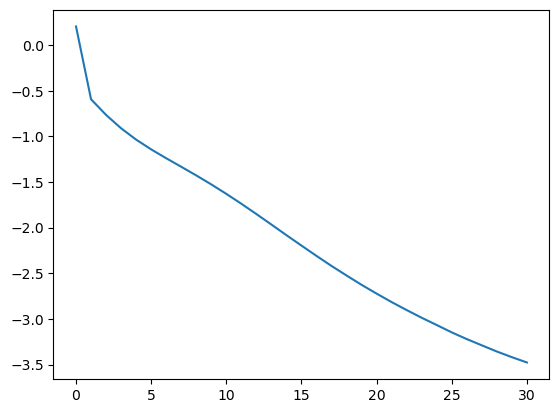

In [11]:
plt.plot(np.log10(np.sum((x_hist - x_cvxpy_test.detach().numpy()[0,:])**2,axis = 1)))

In [18]:
x_cvxpy_test.detach().numpy()[0,:]

array([ 3.66545618e-01, -2.75455075e-10, -1.22103128e-09,  1.45438433e-01,
       -1.94059199e-10,  1.57137647e-01,  1.19169511e-01,  7.75483176e-02,
        1.82705835e-01, -2.88751995e-10,  1.75828323e-01,  3.30099696e-03,
        1.90075964e-01,  1.85005844e-01,  3.82080562e-02,  2.57342070e-01,
        2.06850827e-01,  1.20815210e-01,  2.11700760e-02,  2.31784016e-01,
        9.49936435e-02,  1.93888575e-01,  1.63921803e-01,  3.91377062e-02,
        1.81399226e-01,  1.46353126e-01,  1.13306241e-02,  8.39460237e-11,
        6.46391511e-02,  5.64657412e-02,  9.80337039e-02,  1.68516189e-01,
        2.58844167e-01,  2.43572026e-01,  1.26059011e-01,  1.25921756e-01,
        2.25579426e-01,  4.47541177e-02,  1.83007181e-01,  2.86692709e-01,
        1.63639292e-01,  2.50862688e-01, -1.73734915e-10,  2.04896331e-02,
        4.98930849e-02,  2.13674903e-01,  6.30491897e-02,  1.26736119e-01,
        1.44963592e-01, -3.96767952e-09,  5.95956743e-02,  5.39553091e-02,
        2.88749374e-02, -